In [ ]:
!pip install tf-keras-vis


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.5/52.5 kB 2.7 MB/s eta 0:00:00


In [ ]:
!unzip /content/elpv-dataset-master.zip -d /content/


Archive:  /content/elpv-dataset-master.zip
29f2d70f14120f65f029ce623b8ae73f56832cc7
   creating: /content/elpv-dataset-master/
 extracting: /content/elpv-dataset-master/.gitignore  
  inflating: /content/elpv-dataset-master/CITATION.cff  
  inflating: /content/elpv-dataset-master/LICENSE.md  
  inflating: /content/elpv-dataset-master/README.md  
   creating: /content/elpv-dataset-master/doc/
   creating: /content/elpv-dataset-master/doc/images/
  inflating: /content/elpv-dataset-master/doc/images/overview.jpg  
   creating: /content/elpv-dataset-master/images/
 extracting: /content/elpv-dataset-master/images/cell0001.png  
 extracting: /content/elpv-dataset-master/images/cell0002.png  
 extracting: /content/elpv-dataset-master/images/cell0003.png  
 extracting: /content/elpv-dataset-master/images/cell0004.png  
  inflating: /content/elpv-dataset-master/images/cell0005.png  
 extracting: /content/elpv-dataset-master/images/cell0006.png  
 extracting: /content/elpv-dataset-master/images/

In [ ]:
!pip install tensorflow keras numpy pillow
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split




In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical

# Add utils to the path
import sys
sys.path.append('/content/elpv-dataset-master/utils')

# Import the dataset reader function
from elpv_reader import load_dataset

# Load the dataset
images, proba, types = load_dataset()

# Check data loading
print(f'Number of images: {len(images)}')
print(f'First 5 probabilities: {proba[:5]}')
print(f'First 5 types: {types[:5]}')


Number of images: 2624
First 5 probabilities: [1. 1. 1. 0. 1.]
First 5 types: ['mono' 'mono' 'mono' 'mono' 'mono']


In [ ]:
def load_data():
  images, probas, labels = load_dataset()

  # Convert the type of the solar module
  # to numerical values
  labels[labels == "mono"] = 0
  labels[labels == "poly"] = 1

  # Convert the probabilities to classes
  probas[probas >= 0.5] = 1. # the cell is defective
  probas[probas < 0.5] = 0. # the cell is not defective

  # Convert grayscale to rgb
  # This is needed to adapt the data
  # to the model's input format
  rgb_imgs = np.repeat(images[..., np.newaxis],3,-1)

  # The images and the type of the cell
  # are going to be the inputs to our model
  X1 = rgb_imgs
  X2 = labels

  # The probabilities of being defective
  # are going to be the outputs of our model
  Y = probas

  return X1,X2,Y

X1,X2,Y = load_data()

In [ ]:
min_intensity = np.min(X1)
max_intensity = np.max(X1)

print(f"The range of pixel intensities is between {min_intensity}-{max_intensity}")

The range of pixel intensities is between 0-255


In [ ]:
pos_class = np.sum(Y)/len(Y)*100
neg_class = (len(Y)-np.sum(Y))/len(Y)*100

print(f'The dataset has {np.round(pos_class,2)} % defective cells and {np.round(neg_class,2)} % non-defective cells')


The dataset has 31.29 % defective cells and 68.71 % non-defective cells


In [ ]:
# splitting the dataset
# to train and validation
X1_train,X1_val,Y_train,Y_val = train_test_split(X1,Y,test_size=0.2,random_state=13,stratify=Y)
X2_train,X2_val,Y_train,Y_val = train_test_split(X2,Y,test_size=0.2,random_state=13,stratify=Y)

print(f"Training set size: {X1_train.shape} \nValidation set size: {X1_val.shape}")

Training set size: (2099, 300, 300, 3) 
Validation set size: (525, 300, 300, 3)


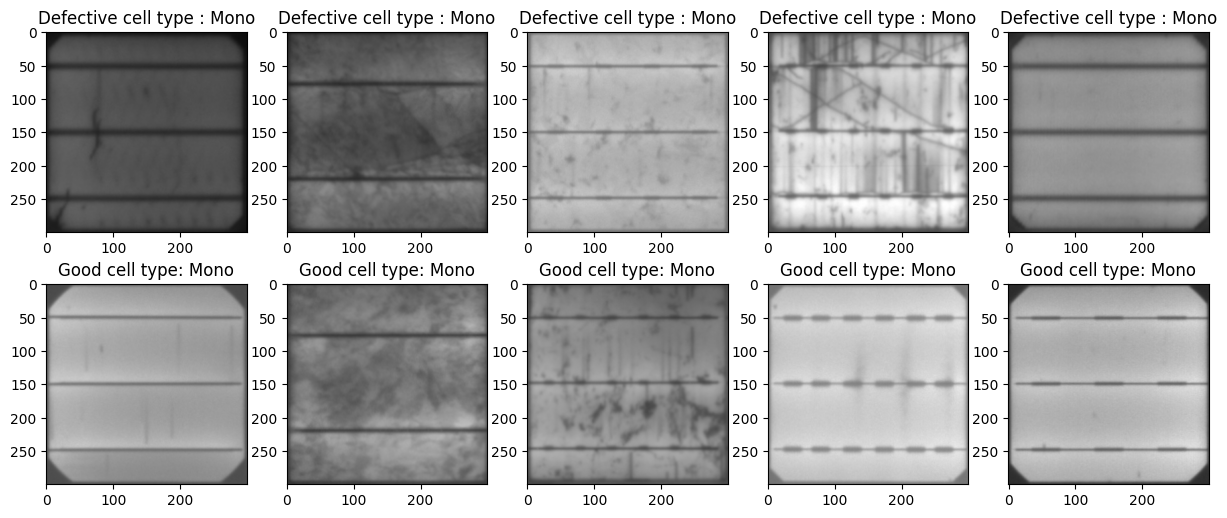

In [ ]:
import matplotlib.pyplot as plt

defective_images = X1_train[Y_train == 1][:10]
non_defective_images = X1_train[Y_train == 0][:5]

cell_types_def = X2_train[Y_train == 1.][:5]
cell_types_ndef = X2_train[Y_train ==0.][:5]

plt.figure(figsize=(15,6))

for i in range(5):
    plt.subplot(2,5,i+1)
    plt.imshow(defective_images[i,...])
    plt.title("Defective cell type : "+ ("Poly" if cell_types_ndef[i-5] == 1 else "Mono"))

for i in range(5,10):
    plt.subplot(2,5,i+1)
    plt.imshow(non_defective_images[i-5,...])
    plt.title(f"Good cell type: "+ ("Poly" if cell_types_ndef[i-5] == 1 else "Mono"))

In [ ]:

pip install tensorflow


In [20]:
Y_train = to_categorical(Y_train,num_classes=2)
Y_val = to_categorical(Y_val,num_classes=2)

In [21]:
BATCH_SIZE = 32
# this is the default size used by most of the pretrained Keras models
image_size = (224, 224)

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        samplewise_center=False,
        samplewise_std_normalization=False,
        rescale=1./255,
        shear_range=0.07, # do some data augmentation here
        zoom_range=0.2,
        rotation_range=30,
        horizontal_flip=True,
        vertical_flip=True)

# create testing and validation data generator without augmentation
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        samplewise_center=False,
        samplewise_std_normalization=False,
        rescale=1./255
        )

In [22]:
train_ds = train_datagen.flow(x=tf.image.resize(X1_train,size=(224,224)),
                              y=Y_train,
                              batch_size=BATCH_SIZE)
val_ds = val_datagen.flow(x=tf.image.resize(X1_val,size=(224,224)),
                          y=Y_val,
                          batch_size=BATCH_SIZE)


In [23]:
def create_transfer_learning_model(
                                   fine_tune=False,
                                   fine_tune_at=None,
                                   input_shape=(224,224,3),
                                   base_learning_rate = 0.01
                                   ):


    inputs = tf.keras.Input(shape=input_shape)
    base_model = tf.keras.applications.EfficientNetV2B2(input_shape=input_shape,
                                                     include_top=False,
                                                     input_tensor=inputs,
                                                     weights='imagenet',
                                                     include_preprocessing=False,
                                                   )
    # Freeze the base model
    base_model.trainable = False

    if fine_tune :
        if not fine_tune_at:
            raise Exception("You should specify from which"+
                            " layer the model will be fine tuned"
                            )
        else:
            base_model.trainable = True

            # Freeze the lowest layers
            # and fine tune the top layers
            # starting from index "fine_tune_at"
            for layer in base_model.layers[:fine_tune_at]:
                layer.trainable = False

    x = base_model.output
    x = layers.BatchNormalization()(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.2)(x)

    outputs = layers.Dense(2,activation="softmax")(x)

    model = tf.keras.Model(inputs, outputs)

    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
                  loss= tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                  metrics=[tf.keras.metrics.CategoricalAccuracy()])
    return model, base_model

model, base_model = create_transfer_learning_model()
model.summary()

35839040/35839040 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 112, 112, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 112, 112, 32)   │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 112, 112, 32)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_project_conv      │ (None, 112, 112, 16)   │          4,608 │ stem_activation[0][0]  │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_project_bn        │ (None, 112, 112, 16)   │             64 │ block1a_project_conv[… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_project_activati… │ (None, 112, 112, 16)   │              0 │ block1a_project_bn[0]… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1b_project_conv      │ (None, 112, 112, 16)   │          2,304 │ block1a_project_activ… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1b_project_bn        │ (None, 112, 112, 16)   │             64 │ block1b_project_conv[… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1b_project_activati… │ (None, 112, 112, 16)   │              0 │ block1b_project_bn[0]… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1b_drop (Dropout)    │ (None, 112, 112, 16)   │              0 │ block1b_project_activ… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1b_add (Add)         │ (None, 112, 112, 16)   │              0 │ block1b_drop[0][0],    │
│                           │                        │                │ block1a_project_activ… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2a_expand_conv       │ (None, 56, 56, 64)     │          9,216 │ block1b_add[0][0]      │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2a_expand_bn         │ (None, 56, 56, 64)     │            256 │ block2a_expand_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├──────────────────────

 Total params: 8,783,456 (33.51 MB)

 Trainable params: 8,450 (33.01 KB)

 Non-trainable params: 8,775,006 (33.47 MB)

In [24]:
import os
import tensorflow as tf

# Define Callbacks to save the best model
if not os.path.exists("./models/"):
    os.makedirs("./models/")

chkp_filepath = "./models/best_efficient_net_b2_final2_{epoch:02d}.keras"
checkpoint = tf.keras.callbacks.ModelCheckpoint(chkp_filepath, verbose=1,
                             save_best_only=True, monitor="val_categorical_accuracy", mode='max', save_freq="epoch")

filename = 'logs_effecient_net_b2_final.csv'
history_logger = tf.keras.callbacks.CSVLogger(filename, separator=",", append=True)

# Custom callback to decrease learning rate by a factor of 3 every 3rd epoch

class DecreaseLR(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if epoch > 4 and epoch % 2 == 0:
            # Get the current learning rate
            old_lr = tf.keras.backend.get_value(self.model.optimizer.learning_rate)

            # Ensure the learning rate is a float
            if isinstance(old_lr, (float, int)):
                new_lr = old_lr / 3
                # Set the new learning rate
                tf.keras.backend.set_value(self.model.optimizer.learning_rate, new_lr)
                print(f"\nEpoch {epoch + 1}: Learning rate decreased from {old_lr} to {new_lr}")
            else:
                print(f"\nEpoch {epoch + 1}: Learning rate is not a float/int, skipping adjustment.")


In [25]:
tf.random.set_seed(64)

initial_epochs = 18

loss0, accuracy0 = model.evaluate(val_ds)

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


17/17 ━━━━━━━━━━━━━━━━━━━━ 52s 3s/step - categorical_accuracy: 0.6281 - loss: 0.6837


In [29]:
from sklearn.utils import class_weight

# Calculate the weights for each class so that we can balance the data
# y = np.argmax(Y_train,axis=-1)
# weights = class_weight.compute_class_weight(class_weight = "balanced",
#                                        classes = np.unique(y),
#                                        y = y)
# weights = dict(zip(np.unique(Y_train), weights))
weights = {0.0: 0.5, 1.0: 1.5}

initial_epochs = 18
history = model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds,
                    callbacks=[history_logger, checkpoint,DecreaseLR()],
                    class_weight=weights
                    )


Epoch 1/18
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.7162 - loss: 0.5314
Epoch 1: val_categorical_accuracy did not improve from 0.80762
66/66 ━━━━━━━━━━━━━━━━━━━━ 248s 4s/step - categorical_accuracy: 0.7161 - loss: 0.5312 - val_categorical_accuracy: 0.7867 - val_loss: 0.5643
Epoch 2/18
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.7177 - loss: 0.5432
Epoch 2: val_categorical_accuracy did not improve from 0.80762
66/66 ━━━━━━━━━━━━━━━━━━━━ 267s 4s/step - categorical_accuracy: 0.7176 - loss: 0.5434 - val_categorical_accuracy: 0.7505 - val_loss: 0.5966
Epoch 3/18
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.7299 - loss: 0.5152
Epoch 3: val_categorical_accuracy did not improve from 0.80762
66/66 ━━━━━━━━━━━━━━━━━━━━ 264s 4s/step - categorical_accuracy: 0.7296 - loss: 0.5153 - val_categorical_accuracy: 0.7810 - val_loss: 0.5617
Epoch 4/18
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.7434 - loss: 0.4370
Epoch 4: va

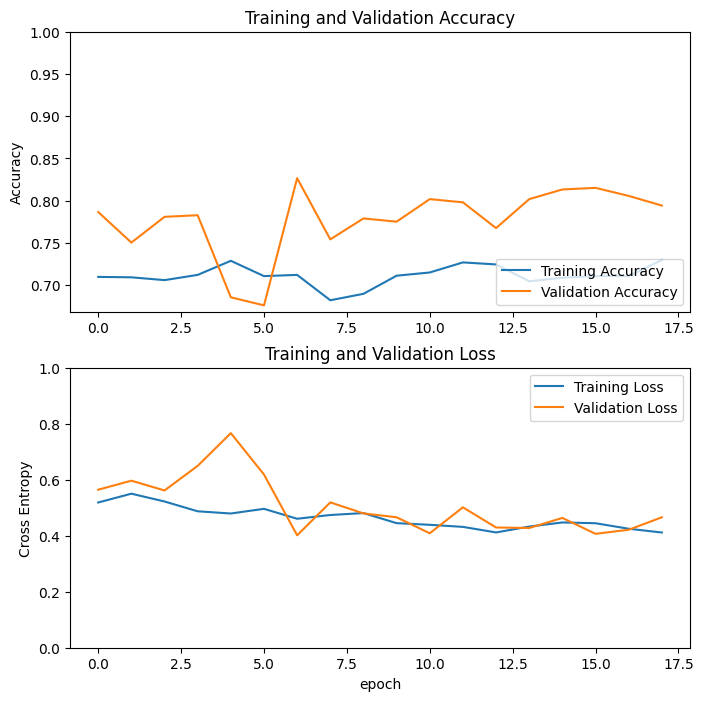

In [30]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [39]:
import os

# List all files in the 'models' directory
model_files = os.listdir("./models/")
print("Model files in './models/' directory:", model_files)


Model files in './models/' directory: ['best_efficient_net_b2_final2_01.keras', 'best_efficient_net_b2_final2_02.keras', 'best_efficient_net_b2_final2_07.keras', 'best_efficient_net_b2_final2_04.keras', 'best_efficient_net_b2_final2_03.keras']


In [40]:
best_model = tf.keras.models.load_model("./models/best_efficient_net_b2_final2_07.keras")



1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


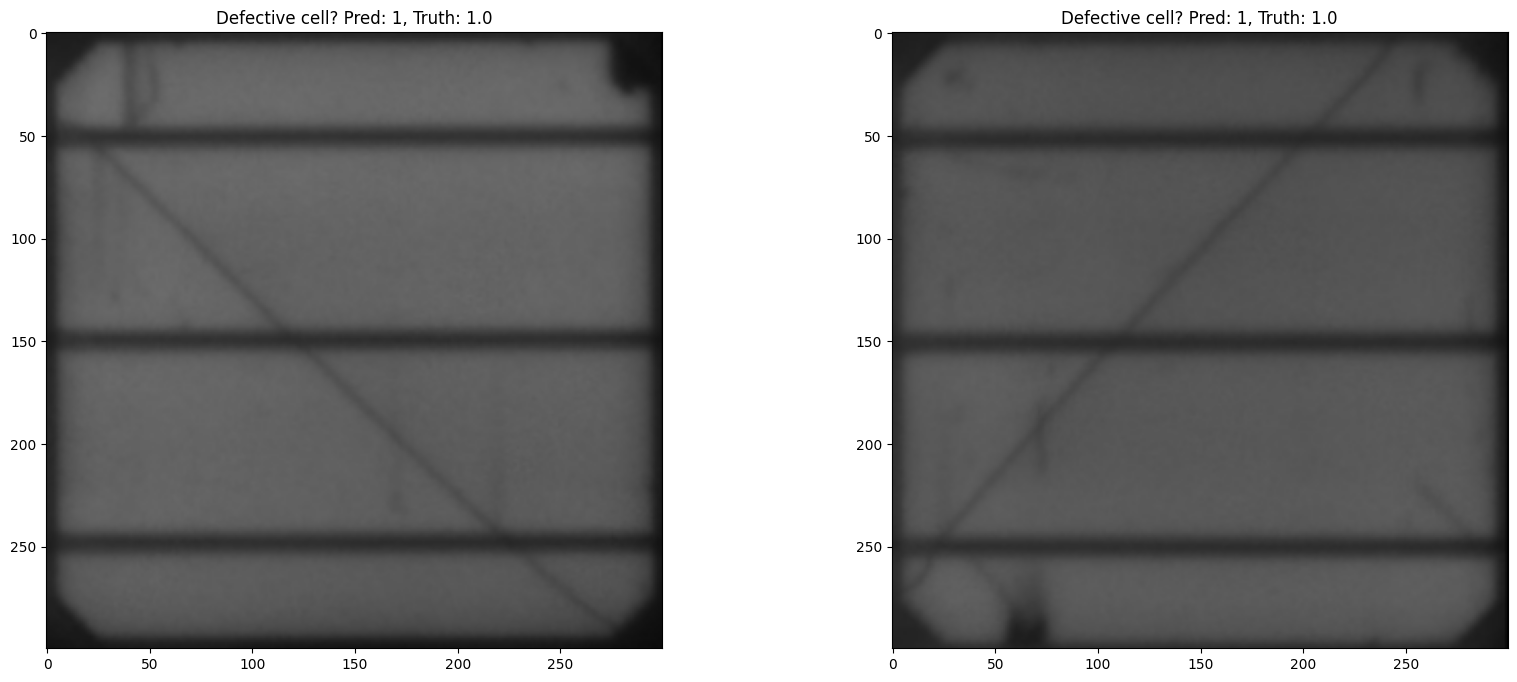

In [41]:
import matplotlib.pyplot as plt
import tensorflow as tf

# Let's load only 2 images
# from the defective cells
# Elsewhere we might run out of resources
# When using GradCam
image_btch = X1[Y == 1][1:3]
labels = Y[Y == 1][1:3]

# Preprocessing the images
images = tf.image.resize(image_btch, size=(224,224)) / 255.

# Running inference
predictions = best_model.predict(images)
predictions = tf.argmax(predictions, axis=-1)

plt.figure(figsize=(20,8))

for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.imshow(image_btch[i,...])
    plt.title(f"Defective cell? Pred: {predictions[i]}, Truth: {labels[i]}")


In [42]:
!pip install tf-keras-vis


In [43]:
from matplotlib import cm
def plot_images(images, maps):
    """
    Plots the images and their corresponding heatmaps side-by-side.

    Args:
        images: An array of images.
        maps: An array of heatmaps.
    """

    fig, axes = plt.subplots(nrows=len(images), ncols=2, figsize=(15, 5))
    if len(images) == 1: # Check if there's only one image
        axes = [axes] # Make axes a list to maintain consistency
    for i,ax in enumerate(axes):
        alpha = 0.3
        image = images[i]
        if len(ax) > 1: # Check if ax is a list of multiple axes
            ax[0].imshow((image+1)/2,alpha=0.7)
            ax[1].imshow(maps[i], cmap='jet', alpha=alpha)
        else:
            ax.imshow((image+1)/2,alpha=0.7)
            ax.imshow(maps[i], cmap='jet', alpha=alpha)

In [44]:
from tf_keras_vis.utils.scores import CategoricalScore
score_function = CategoricalScore(labels.astype('int8').tolist())

In [45]:
def score_function(output):
    # The `output` variable refers to the output of the model,
    # so, in this case, `output` shape is  (samples, nb_classes).
    return [output[i, labels[i].astype('int8')] for i in range(output.shape[0])]

In [46]:
best_model.layers[-6].output.shape

(None, 7, 7, 1408)

In [47]:
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()


In [48]:
from tf_keras_vis.scorecam import Scorecam
# Create ScoreCAM object
scorecam = Scorecam(best_model)
# Generate heatmap with Faster-ScoreCAM
cam = scorecam(score_function, images[1:3],
               penultimate_layer=-6,
               seek_penultimate_conv_layer= False)


44/44 ━━━━━━━━━━━━━━━━━━━━ 152s 3s/step


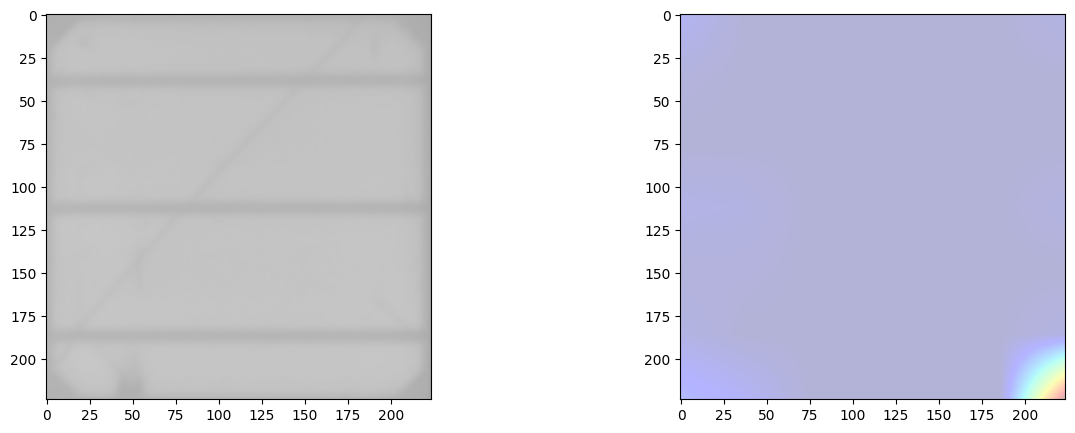

In [49]:
plot_images(images=images[1:3,...], maps=cam)

In [55]:
# Get model predictions
predictions = best_model.predict(images)
defect_prob = predictions[:, 1]  # For class 1 (defect class)

# Get the predicted class
predicted_classes = np.argmax(predictions, axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step


In [57]:

# Print defect probabilities for available images
for i in range(len(defect_prob)):  # Iterate over the length of defect_prob
    print(f'Image {i}: Defect Probability = {defect_prob[i]:.4f}')


Image 0: Defect Probability = 0.9952
Image 1: Defect Probability = 0.9979


In [65]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np

# Define the path to your image
image_path = '/content/elpv-dataset-master/images/cell0052.png'

# Load the image using Keras image loader
img = image.load_img(image_path, target_size=(224, 224))  # Resize the image to match the input size of the model
img_array = image.img_to_array(img)  # Convert the image to a numpy array
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
img_array = img_array / 255.0  # Normalize the image if your model was trained with normalization

# Predict the defect probability using the trained model
predictions = best_model.predict(img_array)

# Assuming your model has binary classification (defect vs. non-defect), get the probability of defect
defect_prob = predictions[0][1]  # If it's binary classification and the defect is the second class

print(f'Defect Probability for cell0052.png: {defect_prob:.4f}')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
Defect Probability for cell0052.png: 0.9463
